In [1]:
from spn.algorithms.Inference import log_likelihood
from spn.algorithms.LearningWrappers import learn_parametric
from spn.structure.Base import Context
from spn.structure.leaves.parametric.Parametric import Categorical, Gaussian, Bernoulli
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm

f = open('msnbc.txt')
next(f)
next(f)
names = next(f).rstrip().split()
next(f)
next(f)
next(f)
next(f)
data = []
for row in tqdm(f, total=989818):
    v = np.zeros(len(names), dtype="bool")
    row = row.rstrip().split(" ")
    for each in row:
        each = int(each) - 1
        v[each] = 1
    data.append(v)

100%|██████████| 989818/989818 [00:27<00:00, 35420.61it/s]


In [2]:
categorical = [True]*len(names)
ptypes = [Bernoulli] * len(names)

data = np.array(data)
data = data[data.sum(axis=1) >= 2]
print (len(data))
train, test = train_test_split(data, random_state = 0)
print ("%d in train, %d in test" % (len(train), len(test)))

388434
291325 in train, 97109 in test


In [3]:
net = learn_parametric(train, 
                       ds_context = Context(parametric_types=ptypes).add_domains(train), 
                       rows = "gmm",
                       min_instances_slice = len(train) / 100)

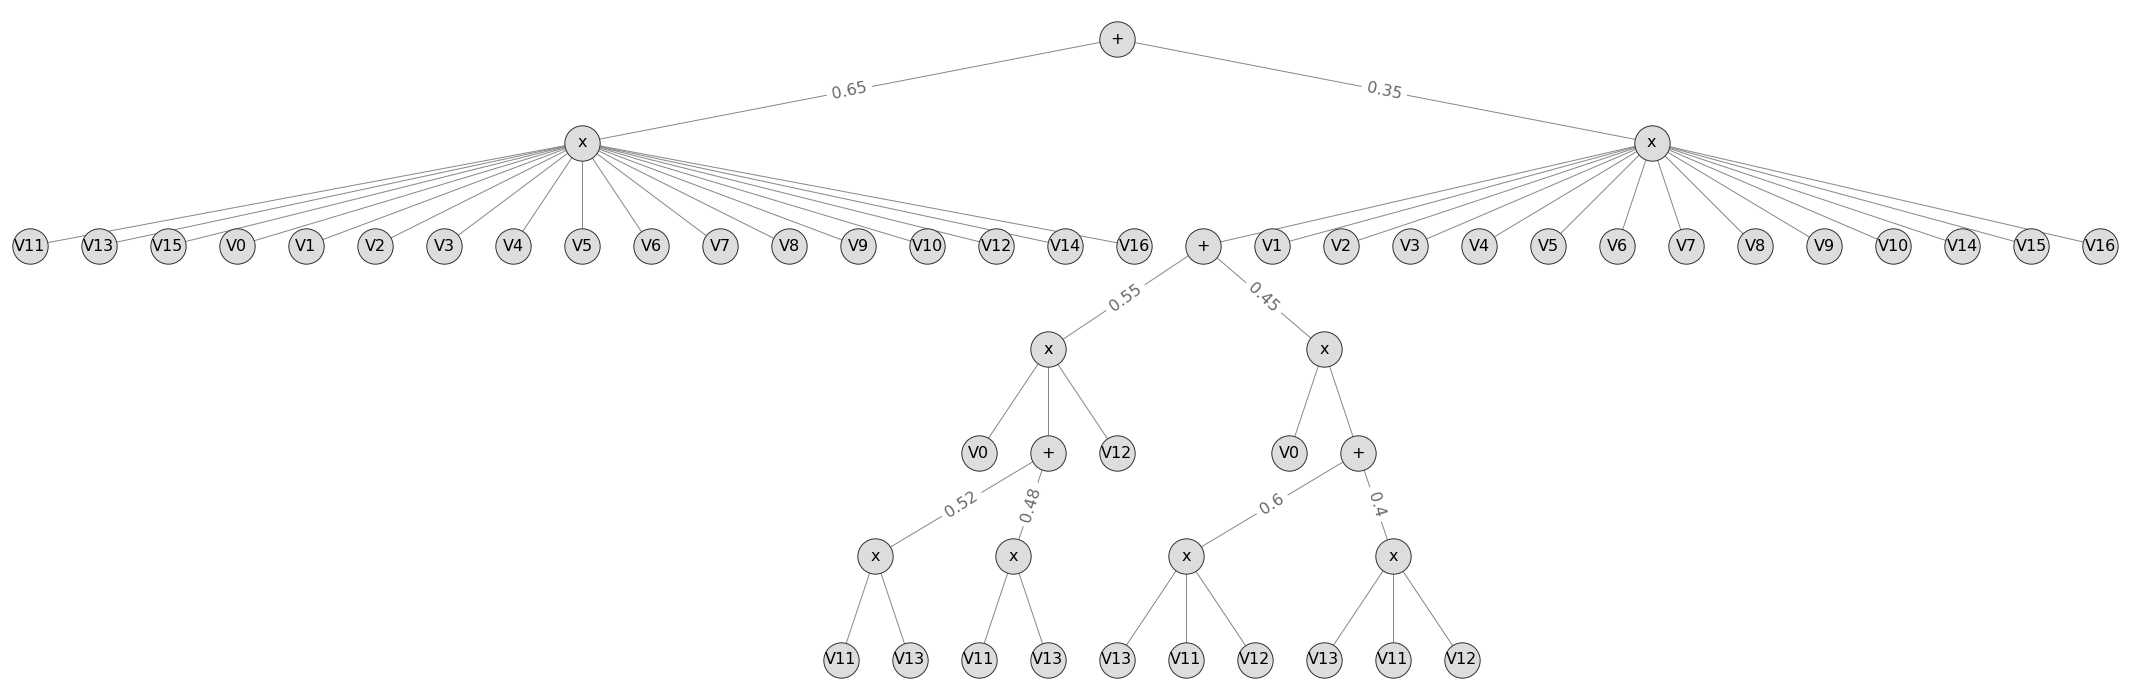

In [4]:
from spn.io.Graphics import plot_spn
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(30, 10))
plot_spn(net)

In [6]:
import csi2
from spn.structure.Base import get_nodes_by_type, Product

def format_condition(condition):
    try:
        a, sign, b = condition.split(" ")
    except ValueError as e:
        raise ValueError("Some nodes don't have conditions. reduce min_impurity_decrease")
    if ((sign, b) == ('==', '1')) or ((sign, b) == ('!=', '0')):
        return ("%s" % (a))
    else:
        return ("~%s" % (a))

print ('#product nodes = ', len(get_nodes_by_type(net, (Product))))
net.n_instances = len(train)
csi2.annotate_spn(net, names, categorical, 
             min_impurity_decrease = 0.1, max_depth = 2)

rules = csi2.context_specific_independences(net, instance_threshold = 0)
csis = []
ac = []
cc = []
for i, rule in enumerate(rules):
    antecedent, consequent, *scores = rule
    A = csi2.format_antecedent(antecedent, format_condition)
    C = csi2.format_consequent(consequent)
    a_count = csi2.antecedent_count(A)
    c_count = csi2.consequent_count(C)
    ac.append(a_count)
    cc.append(c_count)
    csis.append ("{%s} => {%s} | %.2f, %.2f, %d | %d %d" % (A, C, *scores, a_count, c_count))
print ("%d, %.2f, %.2f" % (len(csis), np.mean(ac), np.mean(cc)))

rules = csi2.context_specific_independences(net, instance_threshold = len(train) / 20,
                                           precision_threshold = 0.7, recall_threshold = 0.7)
csis = []
ac = []
cc = []
for i, rule in enumerate(rules):
    antecedent, consequent, *scores = rule
    A = csi2.format_antecedent(antecedent, format_condition)
    C = csi2.format_consequent(consequent)
    a_count = csi2.antecedent_count(A)
    c_count = csi2.consequent_count(C)
    ac.append(a_count)
    cc.append(c_count)
    csis.append ("{%s} => {%s} | %.2f, %.2f, %d | %d %d" % (A, C, *scores, a_count, c_count))
print ("%d, %.2f, %.2f" % (len(csis), np.mean(ac), np.mean(cc)))

#product nodes =  8
8, 4.12, 5.75
8, 4.12, 5.75


In [7]:
from spn.algorithms.Inference import log_likelihood
import numpy as np

print ("test log-likelihood = %.2f" % np.mean(log_likelihood(net, test)))

test log-likelihood = -6.68


/home/saurabh/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
